In [55]:
# import pandas as pd
# import re

# text = "test.txt"

# with open('test.txt', 'r', encoding='utf-8') as file:
#     lines = file.readlines()

# artifacts = {}
# current_key = None
# current_content = []

# for line in lines:
#     line = line.strip()
#     if line.startswith('***** ARTIFACT #'):
#         # Save the previous artifact before starting a new one
#         if current_key is not None:
#             artifacts[current_key] = '\n'.join(current_content).strip()
#    
#         current_key = line.replace('***** ', '').replace(' *****', '')
#         current_content = []
#     else:
#         current_content.append(line)

# if current_key is not None:
#     artifacts[current_key] = '\n'.join(current_content).strip()

# df = pd.DataFrame.from_dict(artifacts, orient='index', columns=['Content'])

# df

# df["Content"]

ARTIFACT #0    URL of artifact ::\thttps://rcweb.dartmouth.ed...
ARTIFACT #1    URL of artifact ::\thttps://rcweb.dartmouth.ed...
ARTIFACT #2    URL of artifact ::\thttps://rcweb.dartmouth.ed...
ARTIFACT #3    URL of artifact ::\thttps://rcweb.dartmouth.ed...
ARTIFACT #4    URL of artifact ::\thttps://rcweb.dartmouth.ed...
Name: Content, dtype: object

In [292]:
import pandas as pd
import time

df = pd.read_csv("REAL Master_Finalized.xlsx - Without Empty Entries.csv")

In [326]:
df_drop = df.drop(['Text',	'Unnamed: 4',	'Unnamed: 5',	'Consensus Code'], axis=1)
df_cleaned = df_drop.dropna(subset=['Citation']).iloc[0:1000]
df_cleaned

,Unnamed: 0,Coding,Citation
2000,citations#1000.xlsx,2,Some of the p rimary policing institutions th...
2001,citations#1000.xlsx,2,Sandy was prepared for him and intended to ki...
2002,citations#1000.xlsx,3,"In this book Franklin also states, “The episo..."
2003,citations#1000.xlsx,2,"In “Slave Patrols ” Kaiser explains, “ Patro..."
2004,citations#1000.xlsx,2,The initial LAPD rep orts say the cops had hi...
...,...,...,...
3008,citations#108.xlsx,SKIP,"(There is a fairly long silence, and then YOUN..."
3009,citations#108.xlsx,SKIP,"(laughs, hesitantly) That sounds like a good i..."
3010,citations#108.xlsx,SKIP,"(Enters, dressed in modern attire, followed by..."
3011,citations#108.xlsx,SKIP,"(OLD glares, then continues.) Anyways, there a..."


In [296]:
import re
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nlp = spacy.load("en_core_web_sm")
analyzer = SentimentIntensityAnalyzer()

In [298]:
#snowball stemmer

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

snow_stemmer = SnowballStemmer(language='english')

stop_words = stopwords.words("english")

def process(text):
    tokens = word_tokenize(text.lower())
    nostop_text = [snow_stemmer.stem(word) for word in tokens if word not in stop_words and word.isalpha()]
    return " ".join(nostop_text)

In [328]:
#process Citation

df_cleaned["cleaned_Citation"] = df_cleaned.Citation.apply(process)

In [322]:
#analyze sentiment on a text

def func(text):
    sent_obj = SentimentIntensityAnalyzer()
    sub = nlp(text)
    entities = set(ent.text for ent in sub.ents)
    
    cleaned_text = text
    
    for ent in entities:
        pattern = re.escape(ent)
        cleaned_text = re.sub(pattern, '', cleaned_text)

    sentiment = sent_obj.polarity_scores(cleaned_text)
    return sentiment

In [330]:
%%time

df_polarized = df_cleaned.cleaned_Citation.apply(func)

df_pol = pd.DataFrame(df_polarized.tolist())
df_score = pd.concat([df_cleaned.reset_index(drop=True),df_pol],axis=1)

CPU times: user 7.38 s, sys: 181 ms, total: 7.56 s
Wall time: 7.63 s


In [332]:
df_score.rename(columns={"Unnamed: 0":"Artifact"},inplace=True)
df_score.head()

,Artifact,Coding,Citation,cleaned_Citation,neg,neu,pos,compound
0,citations#1000.xlsx,2,Some of the p rimary policing institutions th...,p rimari polic institut slave patrol task chas...,0.000,0.909,0.091,0.0258
1,citations#1000.xlsx,2,Sandy was prepared for him and intended to ki...,sandi prepar intend kill knox stab instead los...,0.519,0.481,0.000,-0.8957
2,citations#1000.xlsx,3,"In this book Franklin also states, “The episo...",book franklin also state episod involv knox bi...,0.000,1.000,0.000,0.0000
3,citations#1000.xlsx,2,"In “Slave Patrols ” Kaiser explains, “ Patro...",slave patrol kaiser explain patrol expect chec...,0.000,0.941,0.059,0.1779
4,citations#1000.xlsx,2,The initial LAPD rep orts say the cops had hi...,initi lapd rep ort say cop hit baton sever tim...,0.441,0.559,0.000,-0.7845


In [334]:
df_score.iloc[0].Citation

' Some of the p rimary policing institutions there were the slave patrols tasked with chasing down runaways and preventing slave revolts ” (Waxman).'

In [336]:
df_score["compound_rolled"] = df_score.compound.rolling(30).mean()

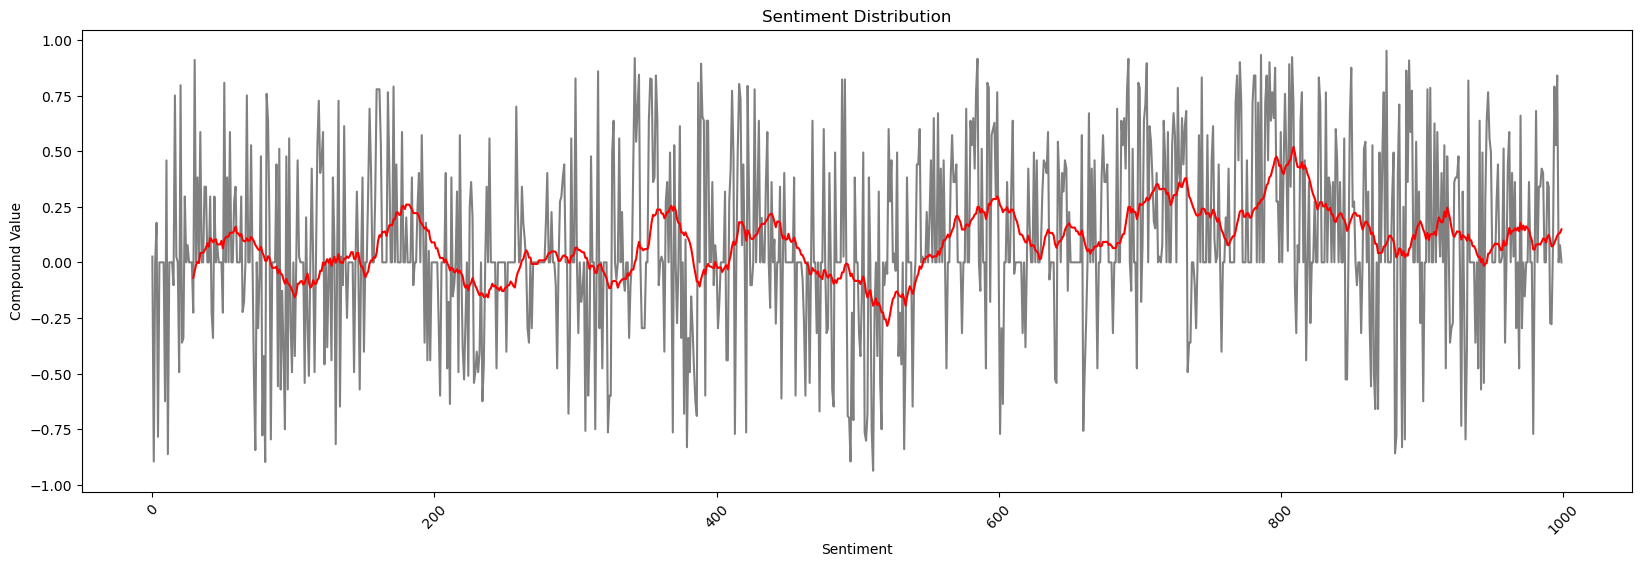

In [338]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
plt.plot(df_score.index, df_score.compound, label="Compound",color="gray")
plt.plot(df_score.index, df_score.compound_rolled, label="Rolled Compound",color="Red")
plt.title("Sentiment Distribution")
plt.xticks(rotation=45)
plt.xlabel("Sentiment")
plt.ylabel("Compound Value")
plt.show()